In [2]:
# Install required libraries
# You can install these packages using pip if not installed:
# !pip install pandas sqlite3 pandasql

import sqlite3
import pandas as pd

# Set working directory
import os
os.chdir("/Users/jade/Desktop/Humana/Training")

# Load datasets using pandas
features_data = pd.read_csv("Afeatures.csv")
control_data = pd.read_csv("Controlpoint.csv")
cost_data = pd.read_csv("CostUt.csv")
demograph_data = pd.read_csv("Demographics.csv")
condition_data = pd.read_csv("mcondition.csv")
detail_data = pd.read_csv("mdetail.csv")
claims_data = pd.read_csv("mclaims.csv")
target_data = pd.read_csv("Tmembers.csv")
members_data = pd.read_csv("mdata.csv")
pharmacy_data = pd.read_csv("PU.csv")
quality_data = pd.read_csv("QD.csv")
sales_data = pd.read_csv("SC.csv")
social_data = pd.read_csv("Socialh.csv")
web_data = pd.read_csv("WA.csv")

/var/folders/wm/7c949vv90fl9xprhlvgygqw40000gn/T/ipykernel_7039/3976071838.py:19: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  claims_data = pd.read_csv("mclaims.csv")
/var/folders/wm/7c949vv90fl9xprhlvgygqw40000gn/T/ipykernel_7039/3976071838.py:23: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  quality_data = pd.read_csv("QD.csv")


In [3]:
import re
def convert_tenure(value):
    # Check if value is a string before processing
    if isinstance(value, str):
        # If the format is 'X - Y YEARS', calculate the midpoint
        if '-' in value and 'YEARS' in value:
            numbers = re.findall(r'\d*\.?\d+', value)
            if len(numbers) == 2:  # Ensure there are two numbers for the range
                return (float(numbers[0]) + float(numbers[1])) / 2
        # If the format is 'X+ YEARS', take the number before the '+'
        elif '+' in value and 'YEARS' in value:
            numbers = re.findall(r'\d*\.?\d+', value)
            if len(numbers) == 1:  # Ensure there's at least one number
                return float(numbers[0])
        # If there's just 'X YEARS', return the number
        elif 'YEARS' in value:
            numbers = re.findall(r'\d*\.?\d+', value)
            if len(numbers) == 1:
                return float(numbers[0])
        # Default case for strings that don't match the expected format
        return None
    # If value is already a float or an int, return it as is
    elif isinstance(value, (float, int)):
        return value
    # Default return for unexpected types (e.g., NaN, None)
    return None

# Applying the function to the column
members_data['tenure_band'] = members_data['tenure_band'].apply(convert_tenure)
members_data['disabled_ind'] = members_data['disabled_ind'].replace({'Y': 1, 'N': 0})
members_data['dual_eligible_ind'] = members_data['dual_eligible_ind'].replace({'Y': 1, 'N': 0})
members_data['lis_ind']= members_data['lis_ind'].replace({'Y': 1, 'N': 0})

In [4]:
merged_data = pd.merge(members_data, pharmacy_data, on='id', how='inner')
merged_data = pd.merge(merged_data, social_data, on='id', how='inner')
merged_data = pd.merge(merged_data, web_data, on='id', how='inner')

In [5]:
new_target=target_data.drop(['product_type','calendar_year','plan_category'],axis=1)
merged_data = pd.merge(merged_data, new_target, on='id', how='inner')
merged_data = pd.merge(merged_data, features_data, on='id', how='inner')
merged_data = pd.merge(merged_data, control_data, on='id', how='inner')
merged_data = pd.merge(merged_data, cost_data, on='id', how='inner')
demograph_data=demograph_data.drop(columns=['lang_spoken_cd', 'rucc_category'])
merged_data = pd.merge(merged_data, demograph_data, on='id', how='inner')

In [6]:
sales_data['channel'] = sales_data['channel'].map({
    'Field':0,
    'Consumer Direct': 1,
    'Partner Call Center': 2,
    'DMS Telesales': 3,
    'Brokerage': 4
})
merged_data = pd.merge(merged_data, sales_data, on='id', how='inner')
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1527904 entries, 0 to 1527903
Columns: 231 entries, consec_tenure_month to channel
dtypes: float64(224), int64(7)
memory usage: 2.6 GB


In [7]:
region_mapping = {region: idx for idx, region in enumerate(detail_data['region'].fillna('Unknown').unique())}
race_mapping = {race: idx for idx, race in enumerate(detail_data['race'].fillna('Unknown').unique())}

# Print the mappings to see what was assigned (optional)
print("Region Mapping:", region_mapping)
print("Race Mapping:", race_mapping)

# Map the 'region' column to numeric values and overwrite the original column
detail_data['region'] = detail_data['region'].fillna('Unknown').map(region_mapping)

# Map the 'race' column to numeric values and overwrite the original column
detail_data['race'] = detail_data['race'].fillna('Unknown').map(race_mapping)
detail_data=detail_data.drop(columns=['mco_contract_nbr','state_of_residence','county_of_residence'])
detail_data['generic_grouper'] = detail_data['generic_grouper'].fillna(10008)
detail_data['generic_grouper'] = detail_data['generic_grouper'].replace({'Y': 1, 'N': 0})
detail_data['unattributed_provider'] = detail_data['unattributed_provider'].fillna(10008)
detail_data['unattributed_provider'] = detail_data['unattributed_provider'].replace({'Y': 1, 'N': 0})
detail_data['sex_cd'] = detail_data['sex_cd'].fillna(10008)
detail_data['sex_cd'] = detail_data['sex_cd'].replace({'F': 1, 'M': 0,'U':10008})
detail_data['veteran_ind'] = detail_data['veteran_ind'].fillna(10008)
detail_data['veteran_ind'] = detail_data['veteran_ind'].replace({'Y': 1, 'N': 0})
merged_data = pd.merge(merged_data, detail_data, on='id', how='inner')

Region Mapping: {'Florida': 0, 'Gulf South': 1, 'South Central': 2, 'Southeast': 3, 'Midwest': 4, 'Northeast': 5, 'Intermountain': 6, 'Central': 7, 'Pacific Southwest': 8, 'Puerto Rico': 9, 'Unknown': 10}
Race Mapping: {'Unknown': 0, 'BLACK': 1, 'N AMERICAN NATIVE': 2, 'WHITE': 3, 'ASIAN': 4, 'HISPANIC': 5, 'UNKNOWN': 6, 'OTHER': 7}


In [8]:
condition_aggregated = condition_data.groupby('id').agg({
    'hcc_model_type': lambda x: ', '.join(x),  # Join diseases as a single string
}).reset_index()
condition_aggregated
def remove_duplicates(hcc_model_type):
    # Split the string into a list, remove duplicates using set, and join it back into a string
    unique_terms = ', '.join(sorted(set(hcc_model_type.split(', '))))
    return unique_terms

# Apply the function to remove duplicates from 'cond_desc' column
condition_aggregated['hcc_model_type'] = condition_aggregated['hcc_model_type'].apply(remove_duplicates)
merged_data = pd.merge(merged_data, condition_aggregated, on='id', how='outer')

In [9]:
merged_data['hcc_model_type'] = merged_data['hcc_model_type'].fillna(0)

# Step 2: Replace specific strings with numeric values
merged_data['hcc_model_type'] = merged_data['hcc_model_type'].replace({'U': 0, 'MEDICAL': 1, 'ESRD': 2})
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1527904 entries, 0 to 1527903
Columns: 241 entries, consec_tenure_month to hcc_model_type
dtypes: float64(224), int64(17)
memory usage: 2.7 GB


In [10]:
# Step 1: Replace 'Y' with 1 and everything else (including NaN) with 0
claims_data_numeric = claims_data.replace({'Y': 1}).fillna(0)

# Step 2: Group by 'id' and sum the numeric values to count the number of 'Y's in each column
claims_data_group = claims_data_numeric.groupby('id', as_index=False).sum()

In [11]:
claims_data_group=claims_data_group.drop(columns = ['dos_year','clm_unique_key','serv_date_skey'])

In [12]:
merged_data = pd.merge(merged_data, claims_data_group, on='id', how='outer')

In [13]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1527904 entries, 0 to 1527903
Columns: 264 entries, consec_tenure_month to er_visit
dtypes: float64(247), int64(17)
memory usage: 3.0 GB


In [14]:
quality_data = quality_data.drop(columns = ['measurement_year','measure_name','measure_desc','base_event_date','eligible_cnt'])
quality_data['measure_type'] = quality_data['measure_type'].fillna(10008)
quality_data['measure_type'] = quality_data['measure_type'].replace({'Patient Safety': 1, 'Patient Experience': 0, 'HEDIS':2})

In [15]:
quality_data_group=quality_data.groupby('id').sum()

In [16]:
merged_data = pd.merge(merged_data, quality_data_group, on='id', how='outer')

In [17]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1527904 entries, 0 to 1527903
Columns: 266 entries, consec_tenure_month to compliant_cnt
dtypes: float64(249), int64(17)
memory usage: 3.0 GB


In [18]:
import os
print(os.getcwd())

/Users/jade/Desktop/Humana/Training


In [19]:
# Install required libraries
# You can install these packages using pip if not installed:
# !pip install pandas sqlite3 pandasql

import sqlite3
import pandas as pd

# Set working directory
import os
os.chdir("/Users/jade/Desktop/Humana/Holdout_final")
# Load datasets using pandas
features_test = pd.read_csv("AFH.csv")
control_test = pd.read_csv("ControlH.csv")
cost_test = pd.read_csv("CostH.csv")
demograph_test = pd.read_csv("DemographH.csv")
condition_test = pd.read_csv("ConditionH.csv")
detail_test = pd.read_csv("DetailH.csv")
claims_test = pd.read_csv("ClaimsH.csv")
target_test = pd.read_csv("TargetH.csv")
members_test = pd.read_csv("MemberH.csv")
pharmacy_test= pd.read_csv("PharmacyH.csv")
quality_test = pd.read_csv("QualityH.csv")
sales_test = pd.read_csv("SalesH.csv")
social_test = pd.read_csv("SocialH.csv")
web_test = pd.read_csv("WebH.csv")

/var/folders/wm/7c949vv90fl9xprhlvgygqw40000gn/T/ipykernel_7039/3321379905.py:18: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  claims_test = pd.read_csv("ClaimsH.csv")
/var/folders/wm/7c949vv90fl9xprhlvgygqw40000gn/T/ipykernel_7039/3321379905.py:22: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  quality_test = pd.read_csv("QualityH.csv")


In [20]:
import re
def convert_tenure(value):
    # Check if value is a string before processing
    if isinstance(value, str):
        # If the format is 'X - Y YEARS', calculate the midpoint
        if '-' in value and 'YEARS' in value:
            numbers = re.findall(r'\d*\.?\d+', value)
            if len(numbers) == 2:  # Ensure there are two numbers for the range
                return (float(numbers[0]) + float(numbers[1])) / 2
        # If the format is 'X+ YEARS', take the number before the '+'
        elif '+' in value and 'YEARS' in value:
            numbers = re.findall(r'\d*\.?\d+', value)
            if len(numbers) == 1:  # Ensure there's at least one number
                return float(numbers[0])
        # If there's just 'X YEARS', return the number
        elif 'YEARS' in value:
            numbers = re.findall(r'\d*\.?\d+', value)
            if len(numbers) == 1:
                return float(numbers[0])
        # Default case for strings that don't match the expected format
        return None
    # If value is already a float or an int, return it as is
    elif isinstance(value, (float, int)):
        return value
    # Default return for unexpected types (e.g., NaN, None)
    return None

# Applying the function to the column
members_test['tenure_band'] = members_test['tenure_band'].apply(convert_tenure)
members_test['disabled_ind'] = members_test['disabled_ind'].replace({'Y': 1, 'N': 0})
members_test['dual_eligible_ind'] = members_test['dual_eligible_ind'].replace({'Y': 1, 'N': 0})
members_test['lis_ind']= members_test['lis_ind'].replace({'Y': 1, 'N': 0})

In [21]:
merged_test = pd.merge(members_test, pharmacy_test, on='id', how='inner')
merged_test = pd.merge(merged_test, social_test, on='id', how='inner')
merged_test = pd.merge(merged_test, web_test, on='id', how='inner')

In [22]:
new_target_test=target_test.drop(['product_type','calendar_year','plan_category'],axis=1)
merged_test = pd.merge(merged_test, new_target_test, on='id', how='inner')
merged_test = pd.merge(merged_test, features_test, on='id', how='inner')
merged_test = pd.merge(merged_test, control_test, on='id', how='inner')
merged_test = pd.merge(merged_test, cost_test, on='id', how='inner')
demograph_test=demograph_test.drop(columns=['lang_spoken_cd', 'rucc_category'])
merged_test = pd.merge(merged_test, demograph_test, on='id', how='inner')

In [23]:
merged_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381976 entries, 0 to 381975
Columns: 229 entries, consec_tenure_month to riskarr_global
dtypes: float64(223), int64(6)
memory usage: 667.4 MB


In [24]:
sales_test['channel'] = sales_test['channel'].map({
    'Field':0,
    'Consumer Direct': 1,
    'Partner Call Center': 2,
    'DMS Telesales': 3,
    'Brokerage': 4
})
merged_test = pd.merge(merged_test, sales_test, on='id', how='inner')
merged_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381976 entries, 0 to 381975
Columns: 230 entries, consec_tenure_month to channel
dtypes: float64(224), int64(6)
memory usage: 670.3 MB


In [25]:
region_mapping = {region: idx for idx, region in enumerate(detail_test['region'].fillna('Unknown').unique())}
race_mapping = {race: idx for idx, race in enumerate(detail_test['race'].fillna('Unknown').unique())}

# Print the mappings to see what was assigned (optional)
print("Region Mapping:", region_mapping)
print("Race Mapping:", race_mapping)

# Map the 'region' column to numeric values and overwrite the original column
detail_test['region'] = detail_test['region'].fillna('Unknown').map(region_mapping)

# Map the 'race' column to numeric values and overwrite the original column
detail_test['race'] = detail_test['race'].fillna('Unknown').map(race_mapping)
detail_test=detail_test.drop(columns=['mco_contract_nbr','state_of_residence','county_of_residence'])
detail_test['generic_grouper'] = detail_test['generic_grouper'].fillna(10008)
detail_test['generic_grouper'] = detail_test['generic_grouper'].replace({'Y': 1, 'N': 0})
detail_test['unattributed_provider'] = detail_test['unattributed_provider'].fillna(10008)
detail_test['unattributed_provider'] = detail_test['unattributed_provider'].replace({'Y': 1, 'N': 0})
detail_test['sex_cd'] = detail_test['sex_cd'].fillna(10008)
detail_test['sex_cd'] = detail_test['sex_cd'].replace({'F': 1, 'M': 0,'U':10008})
detail_test['veteran_ind'] = detail_test['veteran_ind'].fillna(10008)
detail_test['veteran_ind'] = detail_test['veteran_ind'].replace({'Y': 1, 'N': 0})
merged_test = pd.merge(merged_test, detail_test, on='id', how='inner')

Region Mapping: {'Midwest': 0, 'Intermountain': 1, 'Florida': 2, 'Southeast': 3, 'Central': 4, 'South Central': 5, 'Gulf South': 6, 'Pacific Southwest': 7, 'Northeast': 8, 'Puerto Rico': 9, 'Unknown': 10}
Race Mapping: {'Unknown': 0, 'ASIAN': 1, 'WHITE': 2, 'UNKNOWN': 3, 'BLACK': 4, 'HISPANIC': 5, 'OTHER': 6, 'N AMERICAN NATIVE': 7}


In [26]:
merged_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381976 entries, 0 to 381975
Columns: 239 entries, consec_tenure_month to race
dtypes: float64(224), int64(15)
memory usage: 696.5 MB


In [27]:
condition_test = condition_test.groupby('id').agg({
    'hcc_model_type': lambda x: ', '.join(x),  # Join diseases as a single string
}).reset_index()
condition_test
def remove_duplicates(hcc_model_type):
    # Split the string into a list, remove duplicates using set, and join it back into a string
    unique_terms = ', '.join(sorted(set(hcc_model_type.split(', '))))
    return unique_terms

# Apply the function to remove duplicates from 'cond_desc' column
condition_test['hcc_model_type'] = condition_test['hcc_model_type'].apply(remove_duplicates)
merged_test = pd.merge(merged_test, condition_test, on='id', how='outer')

In [28]:
merged_test['hcc_model_type'] = merged_test['hcc_model_type'].fillna(0)

# Step 2: Replace specific strings with numeric values
merged_test['hcc_model_type'] = merged_test['hcc_model_type'].replace({'U': 0, 'MEDICAL': 1, 'ESRD': 2})
merged_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381976 entries, 0 to 381975
Columns: 240 entries, consec_tenure_month to hcc_model_type
dtypes: float64(224), int64(16)
memory usage: 699.4 MB


In [29]:
# Step 1: Replace 'Y' with 1 and everything else (including NaN) with 0
claims_test_numeric = claims_test.replace({'Y': 1}).fillna(0)

# Step 2: Group by 'id' and sum the numeric values to count the number of 'Y's in each column
claims_test_group = claims_test_numeric.groupby('id', as_index=False).sum()

In [30]:
claims_test_group=claims_test_group.drop(columns = ['dos_year','clm_unique_key','serv_date_skey'])

In [31]:
merged_test = pd.merge(merged_test, claims_test_group, on='id', how='outer')

In [32]:
merged_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381976 entries, 0 to 381975
Columns: 263 entries, consec_tenure_month to er_visit
dtypes: float64(247), int64(16)
memory usage: 766.4 MB


In [33]:
quality_test = quality_test.drop(columns = ['measurement_year','measure_name','measure_desc','base_event_date','eligible_cnt'])
quality_test['measure_type'] = quality_test['measure_type'].fillna(10008)
quality_test['measure_type'] = quality_test['measure_type'].replace({'Patient Safety': 1, 'Patient Experience': 0, 'HEDIS':2})

In [34]:
quality_test_group=quality_test.groupby('id').sum()

In [35]:
#merged_test = pd.merge(merged_test, quality_test_group, on='id', how='outer')
merged_testn=pd.merge(merged_test, quality_test_group, on='id', how='outer')

In [36]:
merged_testn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381976 entries, 0 to 381975
Columns: 265 entries, consec_tenure_month to compliant_cnt
dtypes: float64(249), int64(16)
memory usage: 772.3 MB


In [52]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

# Assuming 'merged_data' and 'merged_testn' are pandas DataFrames

# Separate features and target variable from training data
X_train = merged_data.drop(columns=['preventive_visit_gap_ind','id'])  # Drop 'id' from the training features
y_train = merged_data['preventive_visit_gap_ind']

# Extract features from test data (ensure 'id' is dropped for features, but kept for final output)
X_test = merged_testn.drop(columns=['id'])  # Drop 'id' from the test features
test_ids = merged_testn['id']  # Keep 'id' for the final CSV output

# Optional: Scaling (depends on your dataset)
scaler = StandardScaler()

# Scale the data, and keep it as a DataFrame with the same column names
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = scaler.transform(X_test)

# Train XGBoost model (XGBClassifier for classification or XGBRegressor for regression)
xgb_model = xgb.XGBClassifier()  # Replace with XGBRegressor() for regression tasks
xgb_model.fit(X_train_scaled, y_train)

# Predict the scores for test data
test_scores = xgb_model.predict_proba(X_test_scaled)[:, 1]  # For classification, use the probability of the positive class

# Create a DataFrame with original 'id', 'score', and rank based on highest score first
output_df = pd.DataFrame({
    'ID': test_ids,      # Use original patient IDs
    'SCORE': test_scores # Predicted scores
})

# Rank the predictions (highest scores should have rank 1)
output_df['RANK'] = output_df['SCORE'].rank(ascending=False, method='first')

# Sort the DataFrame by 'score' in descending order
output_df_sorted = output_df.sort_values(by='SCORE', ascending=False)

# Optionally reset the index if you want a clean sequential index
output_df_sorted = output_df_sorted.reset_index(drop=True)

# Display the sorted DataFrame
print(output_df_sorted)



             ID     SCORE      RANK
0       1434182  0.999362       1.0
1        328837  0.999113       2.0
2       1706466  0.998837       3.0
3        870396  0.998544       4.0
4       1809237  0.998504       5.0
...         ...       ...       ...
381971  1308999  0.017699  381972.0
381972   116475  0.017301  381973.0
381973  1162195  0.017272  381974.0
381974   396464  0.017170  381975.0
381975   440650  0.014541  381976.0

[381976 rows x 3 columns]


In [53]:
importance = xgb_model.get_booster().get_score(importance_type='weight') 
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
top_10_features = sorted_importance[:10]

# Print the top 10 features with their importance scores
print(top_10_features)

[('compliant_cnt', 133.0), ('total_net_paid_pmpm_cost', 112.0), ('cms_tot_ma_payment_amt', 98.0), ('measure_type', 96.0), ('race', 91.0), ('riskarr_upside', 89.0), ('days_since_last_clm', 88.0), ('cms_tot_partd_payment_amt', 87.0), ('age', 81.0), ('generic_grouper', 78.0)]


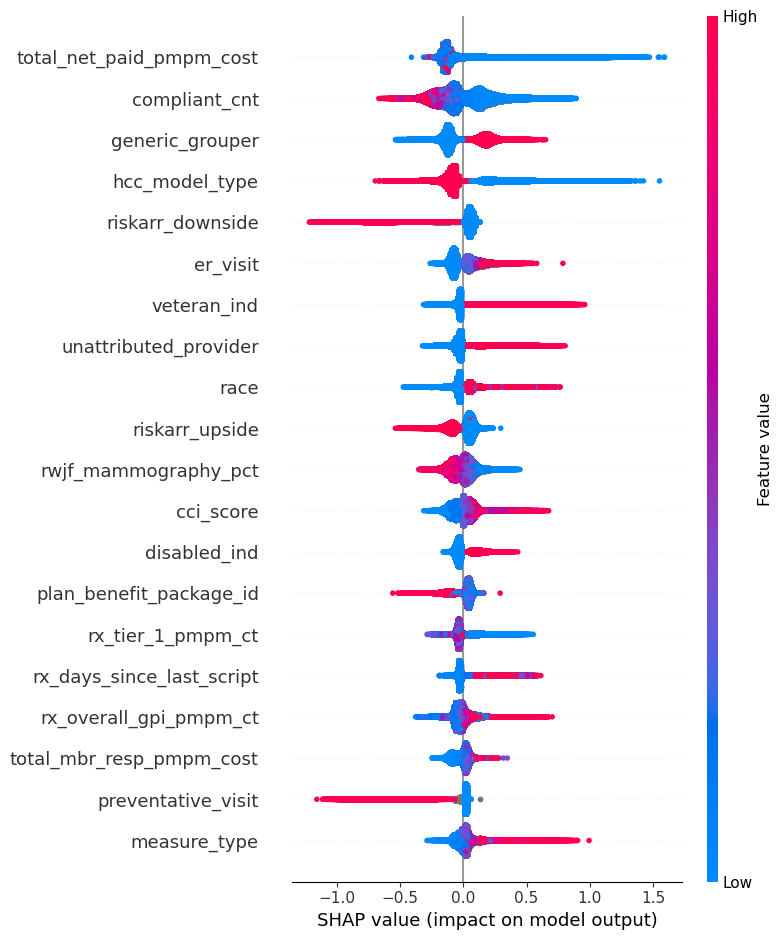

In [59]:
import shap

# Assuming X_train and y_train are your training data
model = xgb.XGBClassifier()
model.fit(X_train_scaled, y_train)

# Use TreeExplainer for XGBoost models
explainer = shap.TreeExplainer(model)

# Get SHAP values for the training data
shap_values = explainer.shap_values(X_train_scaled)

# Plot summary of SHAP values
shap.summary_plot(shap_values, X_train_scaled)

In [61]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_train.iloc[0])